In [33]:
import tqdm
import torch
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.nn.functional import normalize
from src.modeling.network.backbone import ResNet1D, ResNetModel
from src.data.transform import generate_signal_and_label
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, multilabel_confusion_matrix

from torchvision import transforms
from src.config import config
from src.data.stats import GetMeanStd
from src.utils.registry import REGISTRY
from src.utils.trainer import Trainer
from src.modeling.solver.loss import SigmoidFocalLoss
from src.modeling.network.backbone import ResNet1D, ResNetModel, InceptionModel, LSTMNetwork
from src.data.transform import generate_image_and_binary_label, generate_image_and_label
from src.data.transform import generate_signal_and_binary_label, generate_signal_and_label
from src.utils.callbacks import MetricsCallback, EarlyStopper, TensorBoardLogger, CheckpointSaver

In [34]:
MAX_LEN = 16284
BATCH_SIZE = 16
DEVICE = 'cuda'
PATH = 'checkpoints/resnet_18.pkl'

CFG_PATH = "src/config/experiments/resnet18.yaml"

cfg = config.get_cfg_defaults()
cfg.merge_from_file(CFG_PATH)

test_ds = load_dataset("mwritescode/slither-audited-smart-contracts", 'big-multilabel', split='test', ignore_verifications=True)
test_ds = test_ds.filter(lambda elem: elem['bytecode'] != '0x')


if cfg.DATASET.RGB_IMAGES and cfg.DATASET.BINARY_LABELS:
    map_func = generate_image_and_binary_label
elif cfg.DATASET.RGB_IMAGES and not cfg.DATASET.BINARY_LABELS:
    map_func = generate_image_and_label
elif not cfg.DATASET.RGB_IMAGES and cfg.DATASET.BINARY_LABELS:
    map_func = generate_signal_and_binary_label
else:
    map_func = generate_signal_and_label
    
if cfg.DATASET.RGB_IMAGES and cfg.DATASET.BINARY_LABELS:
    map_func = generate_image_and_binary_label
elif cfg.DATASET.RGB_IMAGES and not cfg.DATASET.BINARY_LABELS:
    map_func = generate_image_and_label
elif not cfg.DATASET.RGB_IMAGES and cfg.DATASET.BINARY_LABELS:
    map_func = generate_signal_and_binary_label
else:
    map_func = generate_signal_and_label

test_ds = test_ds.map(map_func, remove_columns=['address', 'source_code', 'bytecode', 'slither'])

max_len = cfg.DATASET.MAX_SEQ_LEN

if cfg.DATASET.RGB_IMAGES:
    img_size = cfg.DATASET.IMG_SHAPE

    if cfg.DATASET.USE_IMAGENET_STATS:
        mean, std = IMAGENET_MEAN, IMAGENET_STD
    else:
        get_stats = GetMeanStd(test_ds, batch_size=16, img_size=img_size)
        mean, std = get_stats()

    img_transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])

padding_val = 0 if cfg.DATASET.NORMALIZE else 256

def img_label_to_tensor(examples):
    if 'image' in examples.keys():
        if cfg.DATASET.RGB_IMAGES:
            examples['image'] = [img_transform(elem) for elem in examples['image']]
        else:
            examples['image'] = [np.pad(img, pad_width=(0, max_len - len(img)), constant_values=padding_val) if len(img) < max_len else img[:max_len] for img in examples['image']]
            if cfg.DATASET.NORMALIZE:
                examples['image'] = [torch.unsqueeze(normalize(torch.tensor(img).float(), dim=0), dim=0) for img in examples['image']]
            else:
                examples['image'] = [torch.tensor(img) for img in examples['image']]

    if 'label' in examples.keys():
        if cfg.DATASET.BINARY_LABELS:
            examples['label'] = torch.unsqueeze(examples['label'], -1)
        else:
            examples['label'] = torch.tensor(examples['label'])
        return examples

test_ds.set_transform(img_label_to_tensor)

Reusing dataset slither-audited-smart-contracts (C:\Users\user\.cache\huggingface\datasets\mwritescode___slither-audited-smart-contracts\big-multilabel\1.1.0\4cf503b59ce9d3157914e47f6253de773b7ab828f46642685d4b470b88ca1f13)
Loading cached processed dataset at C:\Users\user\.cache\huggingface\datasets\mwritescode___slither-audited-smart-contracts\big-multilabel\1.1.0\4cf503b59ce9d3157914e47f6253de773b7ab828f46642685d4b470b88ca1f13\cache-14cd3c70d5f4f921.arrow
Loading cached processed dataset at C:\Users\user\.cache\huggingface\datasets\mwritescode___slither-audited-smart-contracts\big-multilabel\1.1.0\4cf503b59ce9d3157914e47f6253de773b7ab828f46642685d4b470b88ca1f13\cache-90d55d47ce7b32be.arrow
Computing stats..: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 996/996 [00:27<00:00, 35.90it/s]


In [35]:
loader_test = DataLoader(test_ds, batch_size=BATCH_SIZE)

In [36]:
num_cls = cfg.MODEL.N_CLASSES
model_name = cfg.MODEL.NAME
model = REGISTRY[model_name](num_classes=num_cls)
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
model.eval()

ResNetModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [37]:
total_preds = []
total_gt = []
for batch in tqdm.tqdm(loader_test):
    images = batch['image'].to(DEVICE)
    preds = model(images)
    preds = (preds >= 0.0).float().cpu().numpy()
    total_preds.append(preds)
    total_gt.append(batch['label'])

y_pred = np.concatenate(total_preds, axis=0)
y_true = np.concatenate(total_gt, axis=0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 996/996 [00:37<00:00, 26.55it/s]


In [38]:
LABEL_NAMES = ['access-control', 'arithmetic', 'other', 'reentrancy', 'unchecked-calls']
print(classification_report(y_true, y_pred, target_names=LABEL_NAMES, zero_division=0))

                 precision    recall  f1-score   support

 access-control       0.71      0.63      0.67      2331
     arithmetic       0.70      0.62      0.66      2708
          other       0.70      0.70      0.70      4193
     reentrancy       0.78      0.79      0.79      4838
unchecked-calls       0.86      0.84      0.85      7276

      micro avg       0.78      0.75      0.76     21346
      macro avg       0.75      0.71      0.73     21346
   weighted avg       0.78      0.75      0.76     21346
    samples avg       0.49      0.49      0.48     21346



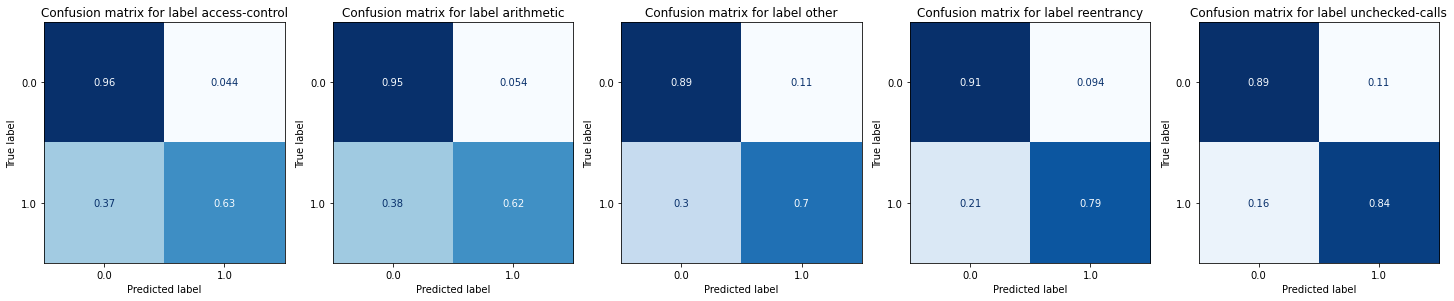

In [39]:
_, axs = plt.subplots(1, len(LABEL_NAMES), figsize=(25, 10))
conf_mat_dict={}

for label_col, ax in zip(range(len(LABEL_NAMES)), axs):
    y_true_label = y_true[:, label_col]
    y_pred_label = y_pred[:, label_col]
    ax.set_title("Confusion matrix for label " + LABEL_NAMES[label_col])
    ConfusionMatrixDisplay.from_predictions(y_true_label, y_pred_label, ax=ax, cmap=plt.cm.Blues, normalize='true', colorbar=False)

plt.show()